## Section 2: Coding Questions

This section consists of coding questions. The total mark for this section is **85**.
The task we are considering in this section is the text classification task. In this section, some code has been provided to help you get started. For each cell marked with **# Insert your code here**, these are placeholders where you **must** supply your own codes when instructed.
This section consists of 5 parts:
* Part 0: Downloading and preprocessing data. This part has been completed. No marks are allocated for this part.
* Part 1: Coding assessment on using Word2Vect to transform texts to vectors (20 marks).
* Part 2: Coding assessment on Text CNN for sequence modeling and neural embedding (10 marks).
* Part 3: Coding assessment on RNNs for sequence modeling and neural embedding (32 marks).
* Part 4: Coding assessment on Transformer for sequence modeling and neural embedding and the overall ranking (23 marks).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [10]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 0: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold"><span></div>

The dataset we use for this assignment is a question classification dataset for which the training set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR),
- entity (ENTY),
- description (DESC),
- human (HUM),
- location (LOC) and
- numeric (NUM).

In this assignment, we will utilize a subset of this dataset, containing $2,000$ questions for training and validation. We will use 80% of those 2000 questions for trainning and the rest for validation.


Preprocessing data is a crucial initial step in any machine learning or deep learning project. The *TextDataManager* class simplifies the process by providing functionalities to download and preprocess data specifically designed for the subsequent questions in this assignment. It is highly recommended to gain a comprehensive understanding of the class's functionality by **carefully reading** the content provided in the *TextDataManager.py* file before proceeding to answer the questions in Part 1.

In [11]:
from TextDataManager import SimpleTextDataset as DataManager

print('Loading data...')
DataManager.maybe_download("data", "train_2000.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("data/", ["train_2000.label"])

Loading data...
Downloaded successfully train_2000.label

Sample questions and corresponding labels... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR']


In [12]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

In [13]:
print(dm.train_str_questions)
print(dm.train_numeral_data.shape)
print(dm.valid_numeral_data.shape)
print(dm.train_numeral_labels.shape)

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?', 'ind what contemptible scoundrel stole the cork from my lunch ?', "gr what team did baseball 's st. louis browns become ?", 'title what is the oldest profession ?', 'def what are liver enzymes ?', 'ind name the scar-faced bounty hunter of the old west .', 'date when was ozzy osbourne born ?', 'reason why do heavier objects travel downhill faster ?', 'ind who was the pride of the yankees ?', 'ind who killed gandhi ?', 'event what is considered the costliest disaster the insurance industry has ever faced ?', 'state what sprawling u.s. state boasts the most airports ?', 'desc what did the only repealed amendment to the u.s. constitution deal with ?', 'count how many jews were executed in conce

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

## <span style="color:#0b486b">Part 1: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 marks]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a classifier using Logistic Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [14]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np

#### <span style="color:red">**Question 1.1**</span>
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [15]:
word2vect = api.load("glove-wiki-gigaword-100") # load dataset

In [16]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)
    except: # word not in the vocabulary
        vector = np.zeros(100)
    return vector

#### <span style="color:red">**Question 1.2**</span>

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[T]\times v[T]$ where $T$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [17]:
def softmax(vector):
    x = np.exp(vector)
    return x / x.sum()

def get_sentence_vector(sentence, important_score=None, model=None):
    sentence = sentence.split(' ')
    length = len(sentence)
    final_vector = np.zeros(100)

    if important_score is None:
        important_score = np.ones(length)

    important_weight = softmax(important_score)

    for i in range(len(sentence)):
        word_vector = get_word_vector(sentence[i], model)
        final_vector += np.dot(important_weight[i], word_vector)

    return final_vector

#### <span style="color:red">**Question 1.3**</span>

**Write code to transform questions in *dm.train_str_questions* and *dm.valid_str_questions* to feature vectors. Note that after running the following cells, you must have $X\_train$ and $X\_valid$ which are two numpy arrays of the feature vectors and $y\_train$ and $y\_valid$ which are two arrays of numeric labels (Hint: *dm.train_numeral_labels* and *dm.valid_numeral_labels*). You can add more lines to the following cells if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div>

In [18]:
def importance_scores(sentence_list, decay_rate=0.9):
    importance = 1
    scores = []
    for i in range(len(sentence_list)):
        scores.append(importance)
        importance *= decay_rate

    return scores

In [19]:
print("Transform training set to feature vectors...")
# Transform training and validation data
X_train = []
y_train = []
for i in range(len(dm.train_str_questions)):
    importance_score = importance_scores(dm.train_str_questions[i].split(' '))
    sentence_vector = get_sentence_vector(dm.train_str_questions[i], importance_score, word2vect)
    X_train.append(sentence_vector)

X_train = np.array(X_train)
y_train = dm.train_numeral_labels

Transform training set to feature vectors...


In [20]:
print("Transform validation set to feature vectors...")
X_valid = []
y_valid = []
for i in range(len(dm.valid_str_questions)):
    importance_score = importance_scores(dm.valid_str_questions[i].split(' '))
    sentence_vector = get_sentence_vector(dm.valid_str_questions[i], importance_score, word2vect)
    X_valid.append(sentence_vector)

X_valid = np.array(X_valid)
y_valid = dm.valid_numeral_labels

Transform validation set to feature vectors...


#### <span style="color:red">**Question 1.4**</span>

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in scikit-learn to scale both training and validation sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [21]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
# scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

#### <span style="color:red">**Question 1.5**</span>
**Train a Logistic Regression model on the training set and then evaluate on the validation set.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [22]:
# Insert your code for training here
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
# Insert your code for validation here
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)

print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.895


### **Embedding visualization**

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $L^2$ norm.**

In [24]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 1.6** </span>

**Write code for the `function find_most_similar(word=None, k=5, model=None)` which returns a list of the top-`k` most similar words (in descending order) for a given word. This similarity is based on the cosine similarity of embedding vectors obtained from the pretrained model `glove-wiki-gigaword-100` (see Question 1.1). The parameter `include_cur_word` specifies whether the given word should be included in the returned output or not. This means that if `include_cur_word=True`, the function will return `k+1` words.**

<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [25]:
def find_most_similar(word=None, k=5, model=None, include_cur_word=False):
    try:
        similarities = []
        word_vector = get_word_vector(word, model)

        for other_word in list(model.key_to_index.keys()):
            similarity = cosine_similarity(get_word_vector(other_word, model), word_vector)
            similarities.append((other_word, similarity, get_word_vector(other_word, model)))

        sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

        top_k_similar_words = []
        top_k_similarities = []
        top_k_embedding = []

        if include_cur_word:
            k += 1
        elif not include_cur_word:
            sorted_similarities.pop(0)

        for word, similarity, embed in sorted_similarities[:k]:
            top_k_similar_words.append(word)
            top_k_similarities.append(similarity)
            top_k_embedding.append(embed)

        return ((top_k_similar_words, top_k_embedding))

    except: # Word not in the vocabulary
        print("Word is not in the dictionary!")

Here is the example of the above function. You can check your implementation using the provided `result`. As you can observe, the `result` makes sense which demonstrates that the embedding matrix is meaningful.

In [26]:
result = ['computer','computers','software','technology','pc','hardware','internet','desktop','electronic','systems','computing']
output = find_most_similar(word='computer', k=10, model=word2vect, include_cur_word=True)[0]
if output == result:
    print("Your implementation is correct.")
else:
    print("Your implementation is not correct.")

Your implementation is correct.


#### <span style="color:red">**Question 1.7** </span>
**Implement the `plot2D_with_groups(word_list, model, k=10)` function to visualize groups of similar words in 2D space. The `word_list` parameter is a list of words, and for each word in the `word_list`, find its top-`k` most similar words (which forms a group) using the `find_most_similar` function. Use tSNE to project embedding vectors into 2D space and plot groups with different colors. You can use the colormaps from `matplotlib`, i.e., `cmap = plt.get_cmap('brg')`.**

**The figure bellow is the output obtained by running `plot2D_with_groups` using the input `word_list=['an', 'introduction', 'to', 'deep', 'learning']`. Note that the words within the `word_list` are also visualized (in black) as shown in the figure.**

<img src="./images/2Dtsne.png" align="center" width=600/>

**As you can observe, words within each group tend to be closer to each other, while words from different groups are more distant.**

<div style="text-align: right"><span style="color:red">[5 marks]</span></div>

In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

def plot2D_with_groups(word_list=None, k=10, model=None):
    all_words = []
    all_embeddings =[]
    # Find the top-k most similar words for each word in the word_list
    for word in word_list:
        similar_words, embeddings = find_most_similar(word, k, model, include_cur_word=True)
        all_words += similar_words
        all_embeddings += embeddings

    all_embeddings = np.array(all_embeddings)
    low_dim_embs = tsne.fit_transform(all_embeddings)

    # Set up a colormap
    cmap = plt.get_cmap('brg')

    # Create a figure and plot the points
    plt.figure(figsize=(10, 10))
    for i, label in enumerate(all_words):
        x, y = low_dim_embs[i, :]
        values = np.linspace(0, 1, len(word_list))
        if label in word_list:
            label_color = 'black'
            scatter_color = cmap(values[i//(k+1)])
            fontweight = 'bold'
        else:
            label_color = cmap(values[i//(k+1)])
            scatter_color = label_color
            fontweight = 'normal'

        plt.scatter(x, y, color=scatter_color)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', color=label_color, ha='right', va='bottom', fontweight=fontweight)

    plt.show()

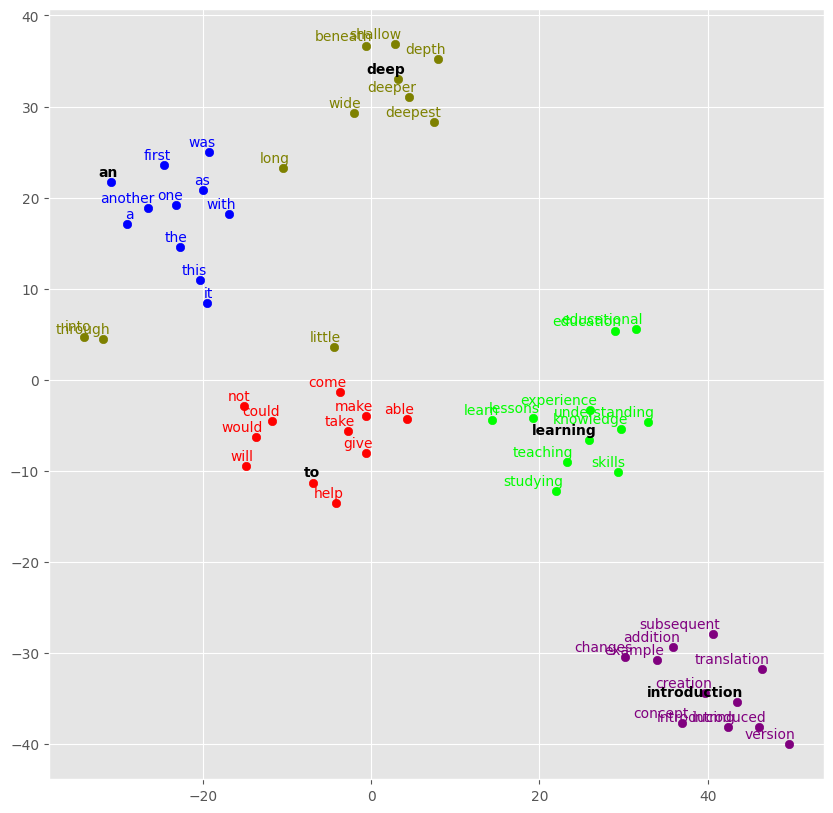

In [28]:
word_list = ['an', 'introduction', 'to', 'deep', 'learning']
plot2D_with_groups(word_list=word_list, k=10, model=word2vect)

## <span style="color:#0b486b">Part 2: Text CNN for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 marks]<span></div>

#### <span style="color:red">**Question 2.1**</span>

**In what follows, you are required to complete the code for Text CNN for sentence classification. The paper of Text CNN can be found at this [link](https://www.aclweb.org/anthology/D14-1181.pdf). Here is the description of the Text CNN that you need to construct.**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times maxlen \times embed\_size]$ as $h$.
  - We feed $h$ to three *Conv1D* layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)) over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  <div style="text-align: right"><span style="color:red">[8 marks]</span></div>
  

In [29]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size, mask_zero=True)(x)
        h1 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=3, padding="same", activation="relu")(h)
        h2 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=5, padding="same", activation="relu")(h)
        h3 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size=7, padding="same", activation="relu")(h)
        h1 = tf.keras.layers.GlobalMaxPool1D()(h1)
        h2 = tf.keras.layers.GlobalMaxPool1D()(h2)
        h3 = tf.keras.layers.GlobalMaxPool1D()(h3)
        h = tf.concat([h1, h2, h3], 1)
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 2.2**</span>
**Here is the code to test TextCNN above. You can observe that TextCNN outperforms the traditional approach Word2Vect with Logistic Regression for this task. The reason is that TextCNN enables us to automatically learn the feature that fits to the task. This makes deep learning different from hand-crafted feature approaches. Complete the code to test the model. Note that when compiling the model, you can use the Adam optimizer.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [30]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()
# Insert your code here
text_cnn.compile_model(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# You are required to compile the model and train the model on 20 epochs
text_cnn.fit(dm.tf_train_set.batch(64), validation_data=dm.tf_valid_set.batch(64),  epochs=20)

Epoch 1/20
25/25 [==============================] - 4s 84ms/step - loss: 1.7204 - accuracy: 0.3775 - val_loss: 1.5810 - val_accuracy: 0.5825
Epoch 2/20
25/25 [==============================] - 2s 72ms/step - loss: 1.3389 - accuracy: 0.7450 - val_loss: 1.1085 - val_accuracy: 0.7825
Epoch 3/20
25/25 [==============================] - 2s 82ms/step - loss: 0.7498 - accuracy: 0.8637 - val_loss: 0.5271 - val_accuracy: 0.9225
Epoch 4/20
25/25 [==============================] - 3s 99ms/step - loss: 0.3204 - accuracy: 0.9531 - val_loss: 0.2628 - val_accuracy: 0.9450
Epoch 5/20
25/25 [==============================] - 2s 75ms/step - loss: 0.1574 - accuracy: 0.9719 - val_loss: 0.1707 - val_accuracy: 0.9625
Epoch 6/20
25/25 [==============================] - 2s 72ms/step - loss: 0.0917 - accuracy: 0.9850 - val_loss: 0.1315 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 2s 75ms/step - loss: 0.0599 - accuracy: 0.9944 - val_loss: 0.1121 - val_accuracy: 0.9625
Epoch 8/20
25

## <span style="color:#0b486b">Part 3: RNN-based models for sequence modeling and neural embedding</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 32 marks]<span></div>

### <span style="color:#0b486b">3.1. RNNs with different cell types</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.1.1**</span>
**In this part, you need to construct a vanilla RNN to learn from the dataset of interest. Basically, you are required to construct the class RNN with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can take one of the three values, i.e., `simple_rnn`, `gru`, or `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 marks]</span></div>

In [31]:
class BaseRNN:
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 64], data_manager=None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size + 1

    # return the corresponding memory cell
    @staticmethod
    def get_layer(cell_type='gru', state_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.GRU(units=state_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            return tf.keras.layers.LSTM(units=state_size, return_sequences=return_sequences, activation=activation)
        else:
            return tf.keras.layers.SimpleRNN(units=state_size, return_sequences=return_sequences, activation=activation)

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            # Insert your code here, you can insert more lines if necessary
            # The last layer should not return previous hidden states
            if i < (num_layers - 1):
                return_sequences = True
            else:
                return_sequences = False
            h = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=return_sequences)(h)

        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 3.1.2**</span>
**Run with simple RNN ('simple_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [32]:
base_rnn = BaseRNN(cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 7s 139ms/step - loss: 0.8340 - accuracy: 0.7169 - val_loss: 0.2514 - val_accuracy: 0.9400
Epoch 2/20
25/25 [==============================] - 3s 118ms/step - loss: 0.1888 - accuracy: 0.9425 - val_loss: 0.1956 - val_accuracy: 0.9250
Epoch 3/20
25/25 [==============================] - 4s 174ms/step - loss: 0.0923 - accuracy: 0.9694 - val_loss: 0.1543 - val_accuracy: 0.9425
Epoch 4/20
25/25 [==============================] - 3s 124ms/step - loss: 0.0672 - accuracy: 0.9825 - val_loss: 0.1089 - val_accuracy: 0.9675
Epoch 5/20
25/25 [==============================] - 3s 124ms/step - loss: 0.0477 - accuracy: 0.9894 - val_loss: 0.0974 - val_accuracy: 0.9625
Epoch 6/20
25/25 [==============================] - 6s 238ms/step - loss: 0.0118 - accuracy: 0.9981 - val_loss: 0.1179 - val_accuracy: 0.9625
Epoch 7/20
25/25 [==============================] - 3s 123ms/step - loss: 0.0203 - accuracy: 0.9962 - val_loss: 0.1086 - val_accuracy: 0.9625
Epoch 

#### <span style="color:red">**Question 3.1.3**</span>
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [33]:
base_rnn = BaseRNN(cell_type='gru', embed_size=128, state_sizes=[64,128], data_manager=dm)# Insert your code here
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 21s 498ms/step - loss: 1.6805 - accuracy: 0.2519 - val_loss: 1.6067 - val_accuracy: 0.2925
Epoch 2/20
25/25 [==============================] - 14s 573ms/step - loss: 1.3077 - accuracy: 0.4506 - val_loss: 0.9543 - val_accuracy: 0.6150
Epoch 3/20
25/25 [==============================] - 11s 415ms/step - loss: 0.6189 - accuracy: 0.7738 - val_loss: 0.4639 - val_accuracy: 0.8725
Epoch 4/20
25/25 [==============================] - 10s 393ms/step - loss: 0.2617 - accuracy: 0.9344 - val_loss: 0.2815 - val_accuracy: 0.9100
Epoch 5/20
25/25 [==============================] - 8s 319ms/step - loss: 0.0934 - accuracy: 0.9794 - val_loss: 0.1767 - val_accuracy: 0.9500
Epoch 6/20
25/25 [==============================] - 10s 391ms/step - loss: 0.0358 - accuracy: 0.9912 - val_loss: 0.1553 - val_accuracy: 0.9500
Epoch 7/20
25/25 [==============================] - 10s 398ms/step - loss: 0.0170 - accuracy: 0.9956 - val_loss: 0.1869 - val_accuracy: 0.9450


#### <span style="color:red">**Question 3.1.4**</span>
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [34]:
base_rnn = BaseRNN(cell_type='lstm', embed_size=128, state_sizes=[64,128], data_manager=dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 22s 523ms/step - loss: 1.6833 - accuracy: 0.2656 - val_loss: 1.5679 - val_accuracy: 0.2800
Epoch 2/20
25/25 [==============================] - 12s 481ms/step - loss: 1.0472 - accuracy: 0.6344 - val_loss: 0.6318 - val_accuracy: 0.8000
Epoch 3/20
25/25 [==============================] - 12s 467ms/step - loss: 0.3977 - accuracy: 0.8706 - val_loss: 0.2503 - val_accuracy: 0.9325
Epoch 4/20
25/25 [==============================] - 11s 445ms/step - loss: 0.1388 - accuracy: 0.9688 - val_loss: 0.1968 - val_accuracy: 0.9375
Epoch 5/20
25/25 [==============================] - 11s 454ms/step - loss: 0.0870 - accuracy: 0.9787 - val_loss: 0.1255 - val_accuracy: 0.9575
Epoch 6/20
25/25 [==============================] - 12s 467ms/step - loss: 0.0552 - accuracy: 0.9862 - val_loss: 0.1187 - val_accuracy: 0.9650
Epoch 7/20
25/25 [==============================] - 10s 407ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.1190 - val_accuracy: 0.9650

#### <span style="color:red">**Question 3.1.5**</span>
**Write code to conduct experiments to compare the accuracies of RNNs with the three different cell types using 2 different lists of `state_sizes` (while the other hyperparameters are fixed). Specifically, for each `state_sizes = [...]`, you should report the accuracies of RNNs with simple RNN ('simple_rnn') cell, GRU ('gru') cell, and LSTM ('lstm') cell. Give your comments on the results.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [35]:
state_sizes_list = [[64, 128], [32, 64, 128]]

for state_sizes in state_sizes_list:
    for cell_type in ['simple_rnn', 'gru', 'lstm']:
        print(f"\nstate_sizes={state_sizes}, cell_type={cell_type}\n")
        # Create and train the RNN model
        base_rnn = BaseRNN(cell_type=cell_type, embed_size=128, state_sizes=state_sizes, data_manager=dm)
        base_rnn.build()
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
        base_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)




state_sizes=[64, 128], cell_type=simple_rnn

Epoch 1/20
25/25 [==============================] - 7s 148ms/step - loss: 0.8814 - accuracy: 0.7013 - val_loss: 0.4181 - val_accuracy: 0.8925
Epoch 2/20
25/25 [==============================] - 3s 125ms/step - loss: 0.1944 - accuracy: 0.9463 - val_loss: 0.1741 - val_accuracy: 0.9325
Epoch 3/20
25/25 [==============================] - 3s 129ms/step - loss: 0.1038 - accuracy: 0.9725 - val_loss: 0.1402 - val_accuracy: 0.9600
Epoch 4/20
25/25 [==============================] - 3s 126ms/step - loss: 0.0740 - accuracy: 0.9787 - val_loss: 0.1141 - val_accuracy: 0.9650
Epoch 5/20
25/25 [==============================] - 3s 126ms/step - loss: 0.0237 - accuracy: 0.9950 - val_loss: 0.0970 - val_accuracy: 0.9700
Epoch 6/20
25/25 [==============================] - 4s 147ms/step - loss: 0.0318 - accuracy: 0.9919 - val_loss: 0.0948 - val_accuracy: 0.9675
Epoch 7/20
25/25 [==============================] - 6s 237ms/step - loss: 0.0047 - accuracy: 0.9994 - 

[64, 128], simple_rnn: 0.9700<br>
[64, 128], gru: 0.9550<br>
[64, 128], lstm: 0.9725<br>
[32, 64, 128], simple_rnn: 0.9650<br>
[32, 64, 128], gru: 0.9650<br>
[32, 64, 128], lstm: 0.9625

#### Comment
Difference between the accuracy of [64, 128] and [32, 64, 128] in simple_rnn: 0.005<br>
Difference between the accuracy of [64, 128] and [32, 64, 128] in gru:0.01. <br>
Difference between the accuracy of [64, 128] and [32, 64, 128] in lstm: 0.01. <br>
LSTM-based model with [64,128] state size has the best accuracy 0.9725. <br>

From the evaluation result of gru cell type we can see that the model accuracy using [32,64,128] state_sizes is better than using [64,128]. This shows that a larger state sizes list can improve the accuracy of the model. However, in simple_rnn and lstm the accuracy using [64, 128] state_sizes is better than using [32,64,128] and from the Epoch of simple_rnn and lstm we can see the gap between training accuracy and validation accuracy using [32,64,128] is larger than using [64,128] this means that the larger state size list may lead to overfitting but the gap is not really big so the overfitting issue is not obvious in this experiment.


### <span style="color:#0b486b">3.2. RNNs with fine-tuning embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 8 marks]<span></div>

#### <span style="color:red">**Question 3.2.1**</span>

**In what follows, you are required to extend the class BaseRNN in Part 3.1 to achieve a class RNN in which the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either 'init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [36]:
class RNN(BaseRNN):
    def __init__(self, run_mode='scratch', embed_model='glove-wiki-gigaword-100', **kwargs):
        super().__init__(**kwargs)
        self.run_mode = run_mode
        self.embed_model = embed_model
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape=[self.vocab_size, self.embed_size])

    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model)
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = get_word_vector(word, self.word2vect)
            except KeyError: # word cannot be found
                pass

    def build(self):
        # Insert your code here to override the 'build' method of BaseRNN
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False, weights=[self.embed_matrix])
        elif self.run_mode == "init-fine-tune":
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True, weights=[self.embed_matrix])

        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            # The last layer should not return previous hidden states
            if i < (num_layers - 1):
                return_sequences = True
            else:
                return_sequences = False
            h = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=return_sequences)(h)

        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)

#### <span style="color:red">**Question 3.2.2**</span>

**Write code to conduct experiments to compare three running modes for the embedding matrix. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments on the results.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [37]:
rnn = RNN(run_mode='scratch', cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))
rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 7s 180ms/step - loss: 0.8774 - accuracy: 0.6888 - val_loss: 0.2810 - val_accuracy: 0.9225
Epoch 2/20
25/25 [==============================] - 3s 131ms/step - loss: 0.1455 - accuracy: 0.9606 - val_loss: 0.1573 - val_accuracy: 0.9550
Epoch 3/20
25/25 [==============================] - 4s 153ms/step - loss: 0.1117 - accuracy: 0.9663 - val_loss: 0.1052 - val_accuracy: 0.9650
Epoch 4/20
25/25 [==============================] - 4s 153ms/step - loss: 0.0342 - accuracy: 0.9919 - val_loss: 0.0915 - val_accuracy: 0.9675
Epoch 5/20
25/25 [==============================] - 3s 126ms/step - loss: 0.0465 - accuracy: 0.9869 - val_loss: 0.0803 - val_accuracy: 0.9675
Epoch 6/20
25/25 [==============================] - 4s 141ms/step - loss: 0.0281 - accuracy: 0.9919 - val_loss: 0.0988 - val_accuracy: 0.9675
Epoch 7/20
25/25 [==============================] - 4s 162ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 0.9650
Epoch 

In [38]:
rnn = RNN(run_mode='init-only', cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))
rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 7s 182ms/step - loss: 1.4882 - accuracy: 0.3769 - val_loss: 1.2037 - val_accuracy: 0.5450
Epoch 2/20
25/25 [==============================] - 3s 118ms/step - loss: 0.8617 - accuracy: 0.6906 - val_loss: 0.6471 - val_accuracy: 0.7750
Epoch 3/20
25/25 [==============================] - 3s 121ms/step - loss: 0.5459 - accuracy: 0.8075 - val_loss: 0.4035 - val_accuracy: 0.8775
Epoch 4/20
25/25 [==============================] - 4s 175ms/step - loss: 0.3401 - accuracy: 0.8856 - val_loss: 0.3087 - val_accuracy: 0.8975
Epoch 5/20
25/25 [==============================] - 3s 114ms/step - loss: 0.2151 - accuracy: 0.9375 - val_loss: 0.1925 - val_accuracy: 0.9325
Epoch 6/20
25/25 [==============================] - 3s 120ms/step - loss: 0.2638 - accuracy: 0.9194 - val_loss: 0.2430 - val_accuracy: 0.9200
Epoch 7/20
25/25 [==============================] - 4s 150ms/step - loss: 0.1475 - accuracy: 0.9613 - val_loss: 0.1780 - val_accuracy: 0.9475
Epoch 

In [39]:
rnn = RNN(run_mode='init-fine-tune', cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))
rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 6s 139ms/step - loss: 1.4320 - accuracy: 0.4162 - val_loss: 0.9281 - val_accuracy: 0.6225
Epoch 2/20
25/25 [==============================] - 3s 130ms/step - loss: 0.7386 - accuracy: 0.7237 - val_loss: 0.5083 - val_accuracy: 0.8300
Epoch 3/20
25/25 [==============================] - 4s 171ms/step - loss: 0.3944 - accuracy: 0.8744 - val_loss: 0.2513 - val_accuracy: 0.9400
Epoch 4/20
25/25 [==============================] - 3s 129ms/step - loss: 0.2227 - accuracy: 0.9362 - val_loss: 0.1674 - val_accuracy: 0.9575
Epoch 5/20
25/25 [==============================] - 3s 130ms/step - loss: 0.1425 - accuracy: 0.9563 - val_loss: 0.2112 - val_accuracy: 0.9350
Epoch 6/20
25/25 [==============================] - 4s 154ms/step - loss: 0.1493 - accuracy: 0.9606 - val_loss: 0.1416 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 3s 130ms/step - loss: 0.0940 - accuracy: 0.9800 - val_loss: 0.2086 - val_accuracy: 0.9475
Epoch 

#### Comment
scratch: 0.9700<br>
init-only: 0.9525<br>
init-fine-tune: 0.9750<br>

The run mode init-fine-tune has the highest accuracy and followed by scratch and then init-only. Init-fine-tune may be the best run mode for embedding matrix because it has the advantages of pre-trained weights with fine-tuning so it has better performance. 

### <span style="color:#0b486b">3.3. RNNs with Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention mechanism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $\textbf{h}_1^L, \textbf{h}_2^L,...,\textbf{h}_{T-1}^L, \textbf{h}_T^L$ be the hidden states at the last hidden layer $L$ where $T$ is the sequence length. We compute the context vector $\textbf{c}$ as $\textbf{c}=\sum_{i=1}^{T}\textbf{a}_{i}\textbf{h}_{i}^L$ where $\textbf{a}_1,...,\textbf{a}_T$ are the alignment weights (i.e., $\textbf{a}_i\geq 0$ and $\sum_{i=1}^{T}\textbf{a}_{i}=1$).**

**The alignment weights are computed as follows:**
- $\textbf{a}=[\textbf{a}_{i}]_{i=1}^{T}=\text{softmax}(\textbf{s})$ where $\textbf{s}= [\textbf{s}_{i}]_{i=1}^{T}$ consists of the alignment scores.
- The alignment scores are computed as $\textbf{s}=\text{tanh}(\textbf{h}^LU)V$ where $\textbf{h}^L=\left[\begin{array}{c}
\textbf{h}_{1}^L\\
\textbf{h}_{2}^L\\
...\\
\textbf{h}_{T-1}^L\\
\textbf{h}_{T}^L
\end{array}\right]\in\mathbb{R}^{T\times state\_size_{L}}$, $U\in\mathbb{R}^{state\_size_{L}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyperparameter. Note that if we consider a mini-batch, the shape of $\textbf{h}^L$ is $(batch\_size, T, state\_size_L)$ where $state\_size_L$ is the hidden size of the last hidden layer. The figure on the right below illustrates the process of calculating a score $\textbf{s}_i$ for an individual hidden state $\textbf{h}_i^L$. Weight matrices $U$ and $V$ are shared across the hidden states $\textbf{h}_1^L,\textbf{h}_2^L,\dots,\textbf{h}_T^L$.

**After having the context vector $\textbf{c}$, we concatenate with the last hidden state $\textbf{h}_T^L$. On top of this concatenation, we conduct the output layer with the softmax activation.**

<img src="./images/attentionRNN.png" align="center" width=700/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.3.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div>

In [40]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length=50):
        super().__init__()
        self.output_length = output_length
        self.U = tf.keras.layers.Dense(self.output_length)
        self.V = tf.keras.layers.Dense(1)

    # all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        alignment_scores = self.V(tf.keras.activations.tanh(self.U(all_states)))
        alignment_weights = tf.nn.softmax(alignment_scores, axis=1)
        context_vector = tf.reduce_sum(tf.linalg.matmul(tf.transpose(alignment_weights, perm=[0,2,1]), all_states), axis=1)
        res = tf.concat([context_vector, last_state], axis=1)
        return res

#### <span style="color:red">**Question 3.3.2**</span>

**You are required to extend the class `RNN` in Question `3.2.1` to achieve the class `AttentionRNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [41]:
class AttentionRNN(RNN):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @staticmethod
    def get_layer(cell_type='gru', state_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.GRU(units=state_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            return tf.keras.layers.LSTM(units=state_size, return_sequences=return_sequences, activation=activation)
        else:
            return tf.keras.layers.SimpleRNN(units=state_size, return_sequences=return_sequences, activation=activation)

    def build(self):
        # Insert your code here to override the 'build' method of BaseRNN
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False, weights=[self.embed_matrix])
        elif self.run_mode == "init-fine-tune":
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True, weights=[self.embed_matrix])

        h = self.embedding_layer(x)
        num_layers = len(self.state_sizes)
        all_state = None
        last_state = None
        for i in range(num_layers):
            # The last layer should not return previous hidden states
            if i < (num_layers - 1):
                return_sequences = True
                h = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=return_sequences)(h)
            else:
                all_state = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=True)(h)
                last_state = self.get_layer(cell_type=self.cell_type, state_size=self.state_sizes[i], return_sequences=False)(h)

        # Attention layer
        attention = MyAttention()
        attention_layer = attention(all_state, last_state)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(attention_layer)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)

#### <span style="color:red">**Question 3.3.3**</span>

**Choose a common setting for standard RNN and RNN with attention and conduct experiments to compare them. The setting here means `run_mode`, `cell_type` and list of `state_sizes`. Give your comments on the results.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [42]:
rnn = RNN(run_mode='scratch', cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 6s 146ms/step - loss: 0.8914 - accuracy: 0.6881 - val_loss: 0.2874 - val_accuracy: 0.9250
Epoch 2/20
25/25 [==============================] - 4s 166ms/step - loss: 0.1958 - accuracy: 0.9413 - val_loss: 0.1650 - val_accuracy: 0.9550
Epoch 3/20
25/25 [==============================] - 3s 130ms/step - loss: 0.1208 - accuracy: 0.9669 - val_loss: 0.1945 - val_accuracy: 0.9250
Epoch 4/20
25/25 [==============================] - 4s 164ms/step - loss: 0.0559 - accuracy: 0.9887 - val_loss: 0.2622 - val_accuracy: 0.8975
Epoch 5/20
25/25 [==============================] - 4s 142ms/step - loss: 0.0545 - accuracy: 0.9850 - val_loss: 0.1250 - val_accuracy: 0.9550
Epoch 6/20
25/25 [==============================] - 3s 130ms/step - loss: 0.0382 - accuracy: 0.9894 - val_loss: 0.1180 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 3s 132ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.1147 - val_accuracy: 0.9575
Epoch 

In [43]:
attention_rnn = AttentionRNN(run_mode='scratch', cell_type='simple_rnn', embed_size=128, state_sizes=[64,128], data_manager=dm)
attention_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
attention_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
attention_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 10s 269ms/step - loss: 0.8297 - accuracy: 0.7125 - val_loss: 0.2120 - val_accuracy: 0.9325
Epoch 2/20
25/25 [==============================] - 5s 192ms/step - loss: 0.1331 - accuracy: 0.9569 - val_loss: 0.1225 - val_accuracy: 0.9600
Epoch 3/20
25/25 [==============================] - 6s 247ms/step - loss: 0.0656 - accuracy: 0.9744 - val_loss: 0.1186 - val_accuracy: 0.9550
Epoch 4/20
25/25 [==============================] - 5s 193ms/step - loss: 0.0413 - accuracy: 0.9887 - val_loss: 0.1021 - val_accuracy: 0.9600
Epoch 5/20
25/25 [==============================] - 6s 248ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.1085 - val_accuracy: 0.9625
Epoch 6/20
25/25 [==============================] - 5s 191ms/step - loss: 0.0525 - accuracy: 0.9850 - val_loss: 0.0900 - val_accuracy: 0.9775
Epoch 7/20
25/25 [==============================] - 6s 242ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0983 - val_accuracy: 0.9700
Epoch

#### Comment
Standard RNN: 0.9675<br>
Attention RNN: 0.9750<br>

Attention RNN perform better because they When generating predictions, RNN can adapt to complicated patterns, handle lengthy sequences more effectively, and concentrate on pertinent portions of the input sequence. This is helpful for jobs like machine translation, where the model must be able to comprehend the meaning of the input sentence in its whole in order to provide a translation that is correct.<br>

However, standard RNNs handle the input sequence sequentially, one token at a time. The model may find it challenging to learn long-range dependencies in the sequence.

## <span style="color:#0b486b">Part 4: Transformer-based models for sequence modeling and neural embedding and the overall ranking</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 23 marks]<span></div>

#### <span style="color:red">**Question 4.1**</span>

**Implement the multi-head attention module of the Transformer for the text classification problem. The provided code is from [this source](https://keras.io/examples/nlp/text_classification_with_transformer/). In this part, we only use the output of the Transformer encoder for the classification task. For further information on the Transformer model, refer to [this paper](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).**

<div style="text-align: right"><span style="color:red">[11 marks]</span></div>

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [45]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = key_dim

        self.wq = tf.keras.layers.Dense(self.embed_dim)
        self.wk = tf.keras.layers.Dense(self.embed_dim)
        self.wv = tf.keras.layers.Dense(self.embed_dim)
        self.wo = tf.keras.layers.Dense(self.embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, (self.embed_dim//self.num_heads)))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(self.wq(inputs))[0]

        q = self.split_heads(self.wq(inputs), batch_size)
        k = self.split_heads(self.wk(inputs), batch_size)
        v = self.split_heads(self.wv(inputs), batch_size)

        # scaled dot product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        attention_weights = tf.nn.softmax(scaled_attention_logits)
        scaled_attention = tf.matmul(attention_weights, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))
        output = self.wo(concat_attention)

        return output




In [46]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [47]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [48]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Sequential

vocab_size = dm.vocab_size + 1
maxlen = dm.maxlen

def create_tfm_model(embed_dim=64, num_heads=8, ff_dim=32, dropout_rate=0.1):
    """
    Creates a Transformer model using the given hyperparameters.

    Parameters:
        embed_dim (int): The embedding dimension for each token.
        num_heads (int): The number of attention heads in the multi-head attention layer.
        ff_dim (int): The hidden layer size in the feed forward network inside the transformer block.
        dropout_rate (float): The dropout rate for regularization.
    Returns:
        keras.models.Sequential: A Transformer model.
    """
    tfm = Sequential()
    tfm.add(Input(shape=(maxlen,)))
    tfm.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    tfm.add(transformer_block)
    tfm.add(GlobalAveragePooling1D())
    tfm.add(Dropout(dropout_rate))
    tfm.add(Dense(units=dm.num_classes, activation='softmax'))
    tfm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return tfm

In [49]:
model = create_tfm_model()
model.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 8s 167ms/step - loss: 1.7206 - accuracy: 0.2350 - val_loss: 1.6394 - val_accuracy: 0.3900
Epoch 2/20
25/25 [==============================] - 4s 173ms/step - loss: 1.5807 - accuracy: 0.3131 - val_loss: 1.5284 - val_accuracy: 0.4475
Epoch 3/20
25/25 [==============================] - 4s 160ms/step - loss: 1.3763 - accuracy: 0.5056 - val_loss: 1.2836 - val_accuracy: 0.5450
Epoch 4/20
25/25 [==============================] - 5s 182ms/step - loss: 0.9125 - accuracy: 0.7525 - val_loss: 0.7532 - val_accuracy: 0.8300
Epoch 5/20
25/25 [==============================] - 4s 173ms/step - loss: 0.3467 - accuracy: 0.9456 - val_loss: 0.3799 - val_accuracy: 0.8925
Epoch 6/20
25/25 [==============================] - 4s 159ms/step - loss: 0.1176 - accuracy: 0.9756 - val_loss: 0.2193 - val_accuracy: 0.9300
Epoch 7/20
25/25 [==============================] - 4s 180ms/step - loss: 0.0397 - accuracy: 0.9931 - val_loss: 0.1546 - val_accuracy: 0.9550
Epoch 

In [50]:
model.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

13/13 [==============================] - 0s 27ms/step - loss: 0.1031 - accuracy: 0.9725


[0.10308230668306351, 0.9725000262260437]

#### <span style="color:red">**Question 4.2**</span>
**Write code to conduct experiments to evaluate the impact of hyperparameters `embed_dim`, `num_heads`, `ff_dim`, and `dropout_rate` of the Transformer model on the accuracy. Report (i) your findings from the experiments, (ii) the accuracy of your best Transformer model (i.e., the one with the highest accuracy on the validation set), and (iii) the values of the mentioned hyperparameters of that best model.  
Note that the necessary condition to get the full mark for this question is that the accuracy of your best Transformer model should be at least 90%.**
<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [51]:
embed_dim = [32, 128]
num_heads = [4,32]
ff_dim = [16, 64]
dropout_rate = [0.01, 0.05, 0.5]

for i in embed_dim:
    for j in num_heads:
        for k in ff_dim:
            for l in dropout_rate:
                print("\n Embed_dim = {} num_heads = {} ff_dim = {} dropout_rate = {}: \n".format(i, j, k, l))
                model = create_tfm_model(embed_dim = i, num_heads = j, ff_dim = k, dropout_rate = l)
                model.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64), verbose=0)
                model.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)


 Embed_dim = 32 num_heads = 4 ff_dim = 16 dropout_rate = 0.01: 

13/13 [==============================] - 0s 24ms/step - loss: 0.0992 - accuracy: 0.9650

 Embed_dim = 32 num_heads = 4 ff_dim = 16 dropout_rate = 0.05: 

13/13 [==============================] - 0s 35ms/step - loss: 0.1048 - accuracy: 0.9650

 Embed_dim = 32 num_heads = 4 ff_dim = 16 dropout_rate = 0.5: 

13/13 [==============================] - 0s 16ms/step - loss: 0.1197 - accuracy: 0.9650

 Embed_dim = 32 num_heads = 4 ff_dim = 64 dropout_rate = 0.01: 

13/13 [==============================] - 0s 19ms/step - loss: 0.1252 - accuracy: 0.9650

 Embed_dim = 32 num_heads = 4 ff_dim = 64 dropout_rate = 0.05: 

13/13 [==============================] - 0s 26ms/step - loss: 0.1559 - accuracy: 0.9625

 Embed_dim = 32 num_heads = 4 ff_dim = 64 dropout_rate = 0.5: 

13/13 [==============================] - 0s 18ms/step - loss: 0.1014 - accuracy: 0.9750

 Embed_dim = 32 num_heads = 32 ff_dim = 16 dropout_rate = 0.01: 

13/13 [====

In [53]:
embed_dim = 128
num_heads = [4,8]
ff_dim = [8,16]
dropout_rate = [0.4,0.7]

for j in num_heads:
    for k in ff_dim:
        for l in dropout_rate:
            print("\n Embed_dim = {} num_heads = {} ff_dim = {} dropout_rate = {}: \n".format(embed_dim, j, k, l))
            model = create_tfm_model(embed_dim = embed_dim, num_heads = j, ff_dim = k, dropout_rate = l)
            model.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64), verbose=0)
            model.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)


 Embed_dim = 128 num_heads = 4 ff_dim = 8 dropout_rate = 0.4: 

13/13 [==============================] - 0s 30ms/step - loss: 0.0768 - accuracy: 0.9825

 Embed_dim = 128 num_heads = 4 ff_dim = 8 dropout_rate = 0.7: 

13/13 [==============================] - 0s 32ms/step - loss: 0.1070 - accuracy: 0.9750

 Embed_dim = 128 num_heads = 4 ff_dim = 16 dropout_rate = 0.4: 

13/13 [==============================] - 0s 32ms/step - loss: 0.0750 - accuracy: 0.9775

 Embed_dim = 128 num_heads = 4 ff_dim = 16 dropout_rate = 0.7: 

13/13 [==============================] - 0s 31ms/step - loss: 0.1036 - accuracy: 0.9750

 Embed_dim = 128 num_heads = 8 ff_dim = 8 dropout_rate = 0.4: 

13/13 [==============================] - 1s 38ms/step - loss: 0.0738 - accuracy: 0.9800

 Embed_dim = 128 num_heads = 8 ff_dim = 8 dropout_rate = 0.7: 

13/13 [==============================] - 0s 37ms/step - loss: 0.0748 - accuracy: 0.9825

 Embed_dim = 128 num_heads = 8 ff_dim = 16 dropout_rate = 0.4: 

13/13 [=======

**(i) Your findings from the experiments (maximum 200 words)**<br>
When comparing the dropout rate we can see that a higher dropout rate will have a higher accuracy:<br>
Embed_dim = 128 num_heads = 4 ff_dim = 16: <br>
dropout_rate = 0.01 accuracy: 0.9750<br>
dropout_rate = 0.05 accuracy: 0.9775<br>
dropout_rate = 0.5 accuracy: 0.9825<br>

But generally higher dropout rate will lead to lower accuracy since it is used to prevent overfitting and if the dropout rate is too high it will lead to underfitting. There are few posibilities having higher dropout rate to have higher accuracy such as noisy or high variability dataset, neural network architecture is complicated, small dataset, etc. These reasons will need higher dropout rate to prevent overfitting. <br>

Example of higher dropout rate with lower accuracy:<br>
Embed_dim = 128 num_heads = 4 ff_dim = 8: <br>
dropout_rate = 0.4 accuracy: 0.9825<br>
dropout_rate = 0.7 accuracy: 0.9750<br>

We can also see that larger embed_dim will have a higher accuracy because embed_dim increases the model's capacity to learn complicated patterns and more resistant to overfitting since higher embed_dim can generalize unseen data better. <br>

From the result we can see that when the num_heads is larger the accuracy is lower because a model with too many attention heads can lead to overfitting if the size of dataset is limited. <br>

Moreover, we can find that the accuracy will become lower when the ff_dim is higher because increase ff_dim more additional parameter will be introduced and this will cause the overparameterization happen. Higher ff_dim may also cause the issue of vanishing or exploding gradients which will lower the model accuracy.<br>

**(ii) The accuracy of your best Transformer model on the validation set**<br>
Highest accuracy: 0.9825

**(iii) The values of the mentioned hyperparameters of your best Transformer model**<br>
Embed_dim = 128 num_heads = 4 ff_dim = 16 dropout_rate = 0.5 (accuracy: 0.9825) <br>
Embed_dim = 128 num_heads = 4 ff_dim = 8 dropout_rate = 0.4 (accuracy: 0.9825) <br>
Embed_dim = 128 num_heads = 8 ff_dim = 8 dropout_rate = 0.7 (accuracy: 0.9825) <br>

#### <span style="color:red">**Question 4.3**</span>
**For any models defined in the previous questions (of all parts), you are free to fine-tune hyperparameters, e.g., `optimizer`, `learning_rate`, `state_sizes`, such that you get a best model, i.e., the one with the highest accuracy on the validation set. You will need to report (i) what is your best model,  (ii) its accuracy on the validation set, and (iii) the values of its hyperparameters. Note that you must report your best model's accuracy with rounding to 4 decimal places, i.e., 0.xxxx. You will also need to upload your best model (or provide us with the link to download your best model). The assessment will be based on your best model's accuracy, with up to 9 marks available, specifically:**
* The best accuracy $\ge$ 0.98: 9 marks
* 0.98 $>$ The best accuracy $\ge$ 0.92: 6 marks
* 0.92 $>$ The best accuracy $\ge$ 0.85: 3 marks
* The best accuracy $<$ 0.85: 0 mark
<div style="text-align: right"><span style="color:red">[9 marks]</span></div>

#### The model with highest accuracy is create_tfm_model() with the below inputs:  <br>

Embed_dim = 128 num_heads = 4 ff_dim = 16 dropout_rate = 0.5:<br>
13/13 [==============================] - 0s 30ms/step - loss: 0.0787 - accuracy: 0.9825
<br><br>
Embed_dim = 128 num_heads = 4 ff_dim = 8 dropout_rate = 0.4: <br>
13/13 [==============================] - 0s 30ms/step - loss: 0.0768 - accuracy: 0.9825
<br><br>
Embed_dim = 128 num_heads = 8 ff_dim = 8 dropout_rate = 0.7: <br>
13/13 [==============================] - 0s 37ms/step - loss: 0.0748 - accuracy: 0.9825

These three best models' hyperparameters will be used to train a model again to get the best model.

In [58]:
best = create_tfm_model(embed_dim = 128, num_heads = 4, ff_dim = 16, dropout_rate = 0.5)
best.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
best.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 8s 217ms/step - loss: 1.9787 - accuracy: 0.1894 - val_loss: 1.6489 - val_accuracy: 0.2125
Epoch 2/20
25/25 [==============================] - 6s 238ms/step - loss: 1.7004 - accuracy: 0.2806 - val_loss: 1.5718 - val_accuracy: 0.3925
Epoch 3/20
25/25 [==============================] - 6s 223ms/step - loss: 1.4995 - accuracy: 0.3887 - val_loss: 1.2399 - val_accuracy: 0.5650
Epoch 4/20
25/25 [==============================] - 5s 188ms/step - loss: 0.7673 - accuracy: 0.7356 - val_loss: 0.2070 - val_accuracy: 0.9300
Epoch 5/20
25/25 [==============================] - 6s 238ms/step - loss: 0.1059 - accuracy: 0.9644 - val_loss: 0.0823 - val_accuracy: 0.9625
Epoch 6/20
25/25 [==============================] - 5s 213ms/step - loss: 0.0404 - accuracy: 0.9894 - val_loss: 0.0607 - val_accuracy: 0.9700
Epoch 7/20
25/25 [==============================] - 5s 188ms/step - loss: 0.0156 - accuracy: 0.9981 - val_loss: 0.0580 - val_accuracy: 0.9725
Epoch 

[0.07130696624517441, 0.9800000190734863]

In [59]:
best1 = create_tfm_model(embed_dim = 128, num_heads = 4, ff_dim = 8, dropout_rate = 0.4)
best1.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
best1.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 9s 255ms/step - loss: 1.9204 - accuracy: 0.2113 - val_loss: 1.6457 - val_accuracy: 0.2125
Epoch 2/20
25/25 [==============================] - 5s 202ms/step - loss: 1.6474 - accuracy: 0.3100 - val_loss: 1.5288 - val_accuracy: 0.2225
Epoch 3/20
25/25 [==============================] - 5s 204ms/step - loss: 1.2703 - accuracy: 0.5450 - val_loss: 1.0145 - val_accuracy: 0.7000
Epoch 4/20
25/25 [==============================] - 6s 241ms/step - loss: 0.5147 - accuracy: 0.8700 - val_loss: 0.1885 - val_accuracy: 0.9350
Epoch 5/20
25/25 [==============================] - 6s 239ms/step - loss: 0.0718 - accuracy: 0.9806 - val_loss: 0.0947 - val_accuracy: 0.9575
Epoch 6/20
25/25 [==============================] - 5s 198ms/step - loss: 0.0201 - accuracy: 0.9956 - val_loss: 0.0693 - val_accuracy: 0.9725
Epoch 7/20
25/25 [==============================] - 6s 247ms/step - loss: 0.0075 - accuracy: 0.9994 - val_loss: 0.0689 - val_accuracy: 0.9700
Epoch 

[0.07647798210382462, 0.9725000262260437]

In [60]:
best2 = create_tfm_model(embed_dim = 128, num_heads = 8, ff_dim = 8, dropout_rate = 0.7)
best2.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
best2.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 10s 289ms/step - loss: 1.9755 - accuracy: 0.2075 - val_loss: 1.7492 - val_accuracy: 0.2125
Epoch 2/20
25/25 [==============================] - 6s 224ms/step - loss: 1.7483 - accuracy: 0.2275 - val_loss: 1.5832 - val_accuracy: 0.2125
Epoch 3/20
25/25 [==============================] - 7s 279ms/step - loss: 1.6164 - accuracy: 0.3044 - val_loss: 1.4591 - val_accuracy: 0.2175
Epoch 4/20
25/25 [==============================] - 6s 262ms/step - loss: 1.3777 - accuracy: 0.4863 - val_loss: 0.9188 - val_accuracy: 0.8225
Epoch 5/20
25/25 [==============================] - 6s 231ms/step - loss: 0.5665 - accuracy: 0.8600 - val_loss: 0.1600 - val_accuracy: 0.9375
Epoch 6/20
25/25 [==============================] - 7s 280ms/step - loss: 0.1140 - accuracy: 0.9737 - val_loss: 0.1071 - val_accuracy: 0.9550
Epoch 7/20
25/25 [==============================] - 6s 225ms/step - loss: 0.0489 - accuracy: 0.9900 - val_loss: 0.0925 - val_accuracy: 0.9675
Epoch

[0.08714498579502106, 0.9775000214576721]

**Result:**<br>
The transformer with embed_dim = 128, num_heads = 4, ff_dim = 16, dropout_rate = 0.5 has the highest accuracy 0.9800.

### Improve the best model by using different hyperparameter

In [88]:
best3 = create_tfm_model(embed_dim = 128, num_heads = 4, ff_dim = 16, dropout_rate = 0.5)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
best3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
best3.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
best3.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 10s 240ms/step - loss: 1.9664 - accuracy: 0.2056 - val_loss: 1.6696 - val_accuracy: 0.2650
Epoch 2/20
25/25 [==============================] - 6s 217ms/step - loss: 1.7238 - accuracy: 0.2619 - val_loss: 1.5948 - val_accuracy: 0.3925
Epoch 3/20
25/25 [==============================] - 5s 196ms/step - loss: 1.4598 - accuracy: 0.4363 - val_loss: 1.2688 - val_accuracy: 0.4775
Epoch 4/20
25/25 [==============================] - 7s 276ms/step - loss: 0.6805 - accuracy: 0.8037 - val_loss: 0.1619 - val_accuracy: 0.9450
Epoch 5/20
25/25 [==============================] - 5s 199ms/step - loss: 0.0793 - accuracy: 0.9762 - val_loss: 0.0830 - val_accuracy: 0.9625
Epoch 6/20
25/25 [==============================] - 5s 196ms/step - loss: 0.0277 - accuracy: 0.9937 - val_loss: 0.0777 - val_accuracy: 0.9700
Epoch 7/20
25/25 [==============================] - 6s 250ms/step - loss: 0.0096 - accuracy: 0.9981 - val_loss: 0.0642 - val_accuracy: 0.9775
Epoch

[0.07499757409095764, 0.9850000143051147]

In [89]:
best3.save("./best_model")

In [90]:
loaded_model = tf.keras.models.load_model("./best_model")

In [91]:
from google.colab import drive
drive.mount('/content/drive')
best3.save("/content/drive/My Drive/best_model")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
loaded_model2 = tf.keras.models.load_model("/content/drive/My Drive/best_model")

\# Give your answer here.

**(i) What is your best model?**<br>
My best model is the transformer(using multihead attention): create_tfm_model(embed_dim=128, num_heads=4, ff_dim=16, dropout_rate=0.5)<br>

**(ii) The accuracy of your best model on the validation set**<br>
Accuracy: 0.9850<br>

**(iii) The values of the hyperparameters of your best model**<br>
optimizer = Adam, learning_rate = 0.001, embed_dim = 128, num_heads = 4, ff_dim = 16, dropout_rate = 0.5<br>

**(iv) The link to download your best model**<br>
https://drive.google.com/drive/folders/1-RUTLyOI9MutTAtYgc-XYQZ26CvkDrt2?usp=sharing

---
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>